In [1]:
import warnings
warnings.simplefilter("ignore",category=DeprecationWarning)

In [2]:
import time
import pandas as pd
import numpy as np
import qiskit
import matplotlib.pyplot as plt
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from sklearn.preprocessing import MinMaxScaler

In [3]:
flat_train = pd.read_csv('flatPrices/train.csv')
flat_test = pd.read_csv('flatPrices/test.csv')

In [4]:
flat_train = flat_train.iloc[:-1]
flat_test = flat_test.iloc[:-1]
flat_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12005 entries, 0 to 12004
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          12005 non-null  float64
 1   town          12005 non-null  int64  
 2   flat_type     12005 non-null  int64  
 3   block         12005 non-null  int64  
 4   latitude      12005 non-null  float64
 5   longitude     12005 non-null  float64
 6   area_sqm      12005 non-null  float64
 7   resale_price  12005 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 750.4 KB


In [5]:
#train_features = ['year','town','flat_type','block','latitude','longitude','area_sqm']

train_data = flat_train.drop(['resale_price'],axis=1)
train_labels = flat_train['resale_price']

test_data = flat_test.drop(['resale_price'],axis=1)
test_labels = flat_test['resale_price']

In [6]:
train_data

,year,town,flat_type,block,latitude,longitude,area_sqm
0,0.988619,3,3,80,1.350414,0.997673,0.377850
1,0.993568,11,3,1142,1.376256,0.999085,0.342020
2,0.991094,0,2,936,1.367239,0.998671,0.237785
3,0.989114,13,3,1127,1.351834,0.997470,0.335505
4,0.994062,12,4,55,1.338773,0.997566,0.390879
...,...,...,...,...,...,...,...
12000,0.989114,8,3,438,1.382013,0.997660,0.342020
12001,0.995547,11,5,155,1.351930,0.998983,0.482085
12002,0.999010,25,2,2091,1.449020,0.998194,0.218241
12003,0.990104,7,1,838,1.285098,0.998594,0.169381


In [7]:
#train_data = train_data.to_numpy()
#train_labels = train_labels.to_numpy()

In [8]:
np.shape(train_data)

(12005, 7)

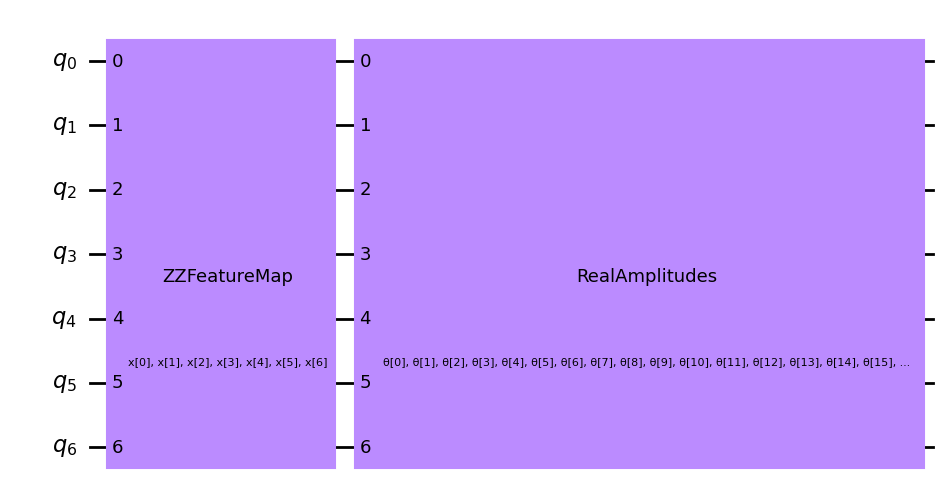

In [9]:
qc = QNNCircuit(num_qubits=7) #number of features
qc.draw('mpl')

In [10]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [11]:
from qiskit.primitives import Estimator
estimator = Estimator()

In [12]:
#train_data = train_data.reshape(len(train_data),1)
#np.shape(train_data)

In [13]:
#backend = qiskit.Aer.get_backend('qasm_simulator')

In [14]:
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService

service = QiskitRuntimeService(
     channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='84e47768480771b0f65f16b3f25447e5ab6b88d174cccb8271d1d0a3e4fdf3ce875e7f9f2612ad64f6f107644f49d8c6d9cd2619469de103753b4ae7556e703a'
)
backend = service.backend('ibmq_qasm_simulator')
estimator = Estimator(backend=backend)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='<IBM Quantum API key>')

In [15]:
regression_estimator_qnn = EstimatorQNN(circuit=qc,estimator=estimator)
regressor = NeuralNetworkRegressor(neural_network=regression_estimator_qnn,
                                   loss='squared_error',
                                   optimizer=L_BFGS_B(maxiter=1))

In [16]:
columns = ['year','town','flat_type','block','latitude','longitude','area_sqm']

scaler = MinMaxScaler()
train_data[columns] = scaler.fit_transform(train_data[columns])
train_labels = scaler.fit_transform(train_labels.to_numpy().reshape(-1,1))
test_data[columns] = scaler.fit_transform(test_data[columns])
#test_labels = scaler.fit_transform(test_labels.to_numpy().reshape(-1,1))

In [17]:
train_data

,year,town,flat_type,block,latitude,longitude,area_sqm
0,0.258065,0.115385,0.500000,0.031987,0.439837,0.203710,0.453608
1,0.580645,0.423077,0.500000,0.456617,0.575584,0.689185,0.396907
2,0.419355,0.000000,0.333333,0.374250,0.528217,0.546921,0.231959
3,0.290323,0.500000,0.500000,0.450620,0.447296,0.134019,0.386598
4,0.612903,0.461538,0.666667,0.021991,0.378686,0.166789,0.474227
...,...,...,...,...,...,...,...
12000,0.290323,0.307692,0.500000,0.175130,0.605823,0.199312,0.396907
12001,0.709677,0.423077,0.833333,0.061975,0.447800,0.654101,0.618557
12002,0.935484,0.961538,0.333333,0.836066,0.957808,0.382951,0.201031
12003,0.354839,0.269231,0.166667,0.335066,0.096738,0.520236,0.123711


In [18]:
#objective_func_vals = []

#start_time = time.time()
#regressor.fit(train_data,train_labels)
#elapsed_time = time.time() - start_time

In [19]:
#print(f"Training time: {round(elapsed_time)} seconds")

In [20]:
#predicted_test_labels = regressor.predict(test_data)
#plt.scatter(test_labels,predicted_test_labels)

In [21]:
#regressor.score(test_data,test_labels)

### Using VQR

In [22]:
feature_map = ZZFeatureMap(7,reps=1,insert_barriers='True')
ansatz = RealAmplitudes(7,reps=1)

In [23]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5))

In [ ]:
start_time = time.time()
vqr.fit(train_data,train_labels)
elapsed_time = time.time()
print(elapsed_time)

KeyboardInterrupt: 

In [ ]:
vqr.score(train_data,train_labels)

In [ ]:
predicted_vqr_test_labels = vqr.predict(test_data)

In [ ]:
plt.scatter(test_labels,predicted_vqr_test_labels)

In [ ]:
predicted_vqr_test_labels

In [ ]:
test_labels